## Survival Analysis:- COXPH, Coxnet , Random Forest Survival, GBM Survival

In [2]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sweetviz as sv
from importlib import reload
np.warnings = warnings

In [3]:
# import utility functions
import src.utils as utils

# Note: to run main notebook from root directory, use:
ROOT_DIR = Path('')
# setup OS agnostic pathnames
# ROOT_DIR = Path('..')

import src.DataLoader as DataLoader
reload(DataLoader)

dataLoader = DataLoader.DataLoader(ROOT_DIR)

In [41]:
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_validate, cross_val_score, RandomizedSearchCV

%matplotlib inline
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
from sklearn.utils.class_weight import compute_sample_weight

from src.utils import filter_missing_rows

from sklearn.preprocessing import StandardScaler

from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

from src.utils import filter_missing_rows
import joblib
import src.engineer_features as ef
from sklearn.exceptions import FitFailedWarning
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

import shap

#### 1.1 Data Cleaning

In [5]:
df_desc_icd, df_desc_labitems, df_desc_items = dataLoader.load_descriptions()
df_diagnoses_icd = dataLoader.load_diagnoses_icd(df_desc_icd)
df_demographic = dataLoader.load_demographic(df_diagnoses_icd)

Removed 8210 admissions with AGE < 18


In [6]:
count_over100 = len(df_demographic[df_demographic.AGE>100])
p_over100 = len(df_demographic[df_demographic.AGE>100])/len(df_demographic)*100
median_age = int(df_demographic['AGE'].median())
print('The number of admissions aged over 100 years old is: {} admissions ({:.2f}% over all admissions)'.format(count_over100, p_over100))
print('The median age of patients: {}'.format(median_age))
df_demographic = dataLoader.demographic_clean_AGE(df_demographic)

The number of admissions aged over 100 years old is: 2616 admissions (5.15% over all admissions)
The median age of patients: 65


In [7]:
df_labevents = dataLoader.load_labevents(df_demographic)
df_labevents = dataLoader.labevents_compute_TIME(df_labevents, df_demographic)

##### 1.2 Data Exploration

In [8]:
df_demographic[df_demographic['IS_SEPSIS'] == 1]["DEATHTIME"].isna().value_counts()

DEATHTIME
True     3581
False    1595
Name: count, dtype: int64

#### Data Loader

In [9]:
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=0, feature_no=40)
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=2, feature_no=40)
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=8, feature_no=40)

## 2.1 Survival Analysis on t8 Dataset

In [10]:
path_t8_df = ROOT_DIR / 'data' / 'Model input data'/"t8.csv"  
t8 = pd.read_csv(path_t8_df)

In [11]:
df_demographic['last_seen'] = df_demographic['DEATHTIME'].fillna(df_demographic['DISCHTIME'])
df_demographic['last_seen'] =  pd.to_datetime(df_demographic['last_seen'], format='%Y-%m-%d %H:%M:%S')
df_demographic["total_stay"]  = (df_demographic["last_seen"] - df_demographic["ADMITTIME"]).dt.total_seconds() / 3600
df_demographic["total_stay"] = df_demographic["total_stay"].round()
df_demographic["status"] = df_demographic["DEATHTIME"].notna()

In [12]:
#dropping the rows which have negative total stay i.e. discharge time less than admit time
df_demographic = df_demographic[df_demographic["total_stay"] >= 0]

In [13]:
df_required = pd.merge(t8, df_demographic[["SUBJECT_ID","HADM_ID","total_stay","status"]] , on=["SUBJECT_ID","HADM_ID"], how = 'inner')



In [14]:
df_required

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,...,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status
0,3,145834,76,0,0,15.0,267.0,5.0,33.0,7.26,...,81.0,253.0,15.6,46.4,15.3,2.79,19.1,-999.0,259.0,False
1,4,185777,47,1,0,21.0,-999.0,2.1,28.0,7.47,...,89.6,207.0,12.3,31.3,13.6,3.80,9.7,-999.0,186.0,False
2,6,107064,65,1,0,16.0,174.0,3.9,31.0,7.31,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,393.0,False
3,9,150750,41,0,0,29.0,178.0,1.9,46.0,7.39,...,50.1,258.0,12.7,21.7,13.4,5.46,7.5,0.0,117.0,True
4,11,194540,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,91.4,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,613.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48339,99983,117390,78,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,-999.0,253.0,13.4,27.0,12.7,4.21,7.5,-999.0,74.0,False
48340,99985,176670,53,0,1,-999.0,-999.0,1.9,-999.0,-999.00,...,86.3,349.0,-999.0,-999.0,13.7,4.29,17.9,-999.0,398.0,False
48341,99992,197084,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,84.9,188.0,12.9,43.9,16.3,1.35,21.4,-999.0,72.0,False
48342,99995,137810,88,1,0,35.0,110.0,1.3,46.0,7.48,...,-999.0,189.0,15.4,27.9,18.1,2.86,8.2,-999.0,77.0,False


In [15]:
# to add sofa score for respective admissions
df_required['sofa_score'] = ef.get_sofa_score(df=df_required)

In [16]:
df_required

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,...,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status,sofa_score
0,3,145834,76,0,0,15.0,267.0,5.0,33.0,7.26,...,253.0,15.6,46.4,15.3,2.79,19.1,-999.0,259.0,False,4
1,4,185777,47,1,0,21.0,-999.0,2.1,28.0,7.47,...,207.0,12.3,31.3,13.6,3.80,9.7,-999.0,186.0,False,4
2,6,107064,65,1,0,16.0,174.0,3.9,31.0,7.31,...,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,393.0,False,-999
3,9,150750,41,0,0,29.0,178.0,1.9,46.0,7.39,...,258.0,12.7,21.7,13.4,5.46,7.5,0.0,117.0,True,-999
4,11,194540,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,613.0,False,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48339,99983,117390,78,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,253.0,13.4,27.0,12.7,4.21,7.5,-999.0,74.0,False,-999
48340,99985,176670,53,0,1,-999.0,-999.0,1.9,-999.0,-999.00,...,349.0,-999.0,-999.0,13.7,4.29,17.9,-999.0,398.0,False,2
48341,99992,197084,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,188.0,12.9,43.9,16.3,1.35,21.4,-999.0,72.0,False,4
48342,99995,137810,88,1,0,35.0,110.0,1.3,46.0,7.48,...,189.0,15.4,27.9,18.1,2.86,8.2,-999.0,77.0,False,5


In [17]:
# dropping the patients who have sepsis but not died untill discharge

df_required = df_required.drop(df_required[(df_required['IS_SEPSIS']==1) & (df_required['status']==False)].index)


In [18]:
# censored and non-censored count of instances
df_required["status"].value_counts()

status
False    39260
True      5570
Name: count, dtype: int64

In [19]:
df_required = df_required.drop(["SUBJECT_ID","HADM_ID"], axis = 1)
#DROPPINg the 70% missing values rows
df_required = filter_missing_rows(df_required, 70) 

In [20]:
# splitting of data into training and test set
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(
    #df_required.drop(["status","total_stay","IS_SEPSIS"], axis=1),  # dropping the target column for X values
    df_required.drop(["status","total_stay"], axis=1),  # dropping the target column for X values
    df_required[["status","total_stay"]],
    test_size=0.2,  # this means 20% test set
    stratify=df_required['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)

In [21]:
len(data_y_train[(data_x_train["IS_SEPSIS"]==0) ])

32860

<Axes: >

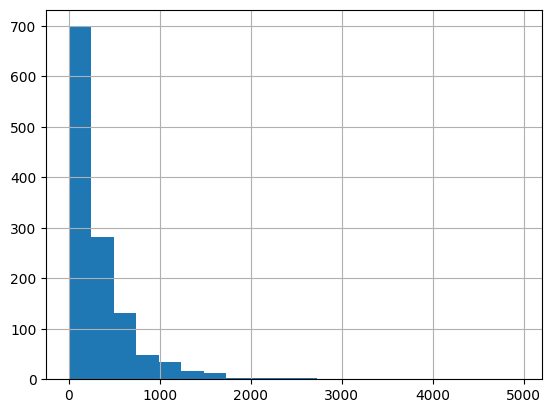

In [22]:
data_y_train[(data_x_train["IS_SEPSIS"]==1) ]['total_stay'].hist(bins=20)

In [23]:
# Standard Scalerisation
train_categorical = pd.DataFrame(data_x_train[["GENDER_NUM","IS_SEPSIS"]]).reset_index(drop=True)
test_categorical = pd.DataFrame(data_x_test[["GENDER_NUM","IS_SEPSIS"]]).reset_index(drop=True)

scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(data_x_train.drop(["GENDER_NUM","IS_SEPSIS"], axis=1))
scaled_x_train_columns= data_x_train.drop(["GENDER_NUM","IS_SEPSIS"], axis=1).columns

scaled_x_test = scaler.transform(data_x_test.drop(["GENDER_NUM","IS_SEPSIS"], axis=1))
scaled_x_test_columns= data_x_test.drop(["GENDER_NUM","IS_SEPSIS"], axis=1).columns

data_x_train = pd.DataFrame(scaled_x_train, columns=scaled_x_train_columns)
data_x_test = pd.DataFrame(scaled_x_test, columns=scaled_x_test_columns)
data_x_train = pd.concat([data_x_train, train_categorical], axis=1)
data_x_test = pd.concat([data_x_test, test_categorical], axis=1)

# dropping of sepsis column from the respective training  and test data
data_x_train = data_x_train.drop(["IS_SEPSIS"], axis = 1)
test_sepsis = data_x_test["IS_SEPSIS"]    # labesls of sepsis of test data
data_x_test = data_x_test.drop("IS_SEPSIS", axis = 1)

In [24]:
# conversion to structured format
data_y_train = data_y_train.to_records(index=False)
data_y_test = data_y_test.to_records(index=False)
data_y_train

rec.array([(False,  148.), (False,  104.), (False,  237.), ...,
           (False,  143.), (False, 1276.), (False,  290.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

In [25]:
data_y_train.dtype

dtype((numpy.record, [('status', '?'), ('total_stay', '<f8')]))

### 1. Cox PH Survival Model

In [25]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_train, data_y_train)

CoxPHSurvivalAnalysis()

In [26]:
# prediction of survival risk 
pred_surv = estimator.predict_survival_function(data_x_test[1800:1900])


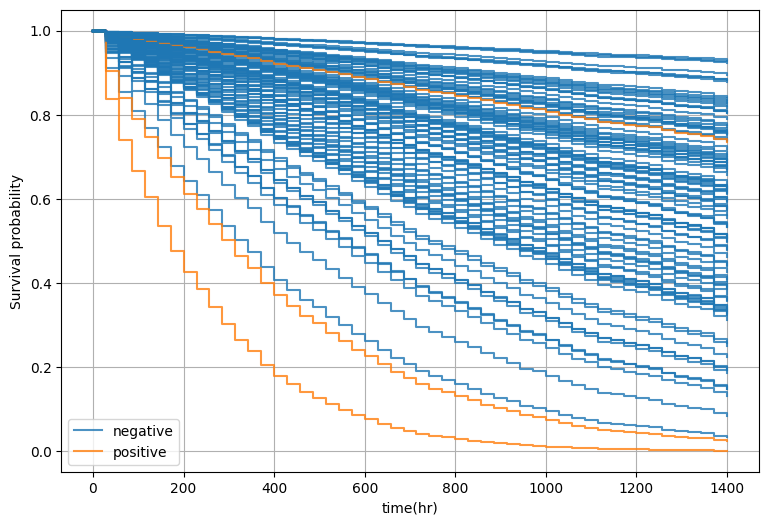

In [27]:

time_points =  np.linspace(0, 1400)
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(pred_surv, test_sepsis[1800:1900]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.8)
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time(hr)")
ax.set_ylabel("Survival probability")
ax.grid(True)

In [28]:
# Concordance index score
print(estimator.score(data_x_test, data_y_test))

0.7417331825496066


In [29]:
# which single variable is best risk predictor
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x_train.values, data_y_train)

#displaying the top 10 features having large coefficient
pd.Series(scores, index=data_x_train.columns).sort_values(ascending=False)[:10]

ITEMID_50813    0.652917
ITEMID_51006    0.625366
ITEMID_51274    0.609227
ITEMID_51237    0.608299
ITEMID_50821    0.606154
ITEMID_51144    0.604917
ITEMID_51301    0.604151
ITEMID_50912    0.602611
ITEMID_50818    0.601938
ITEMID_51277    0.594877
dtype: float64

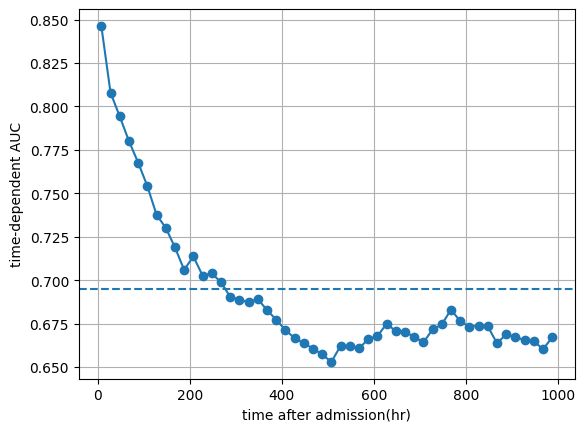

In [30]:
# Time-independent AUC curve
va_times = np.arange(8, 1000, 20)
cph_risk_scores = estimator.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, cph_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

### 2. Coxnet Survival model

In [31]:
Xt = data_x_train.copy()
y = data_y_train.copy()

In [32]:

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=100))
#warnings.simplefilter("ignore", UserWarning)
#warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.001, l1_ratio=0.9,
                                        max_iter=100))])

In [33]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

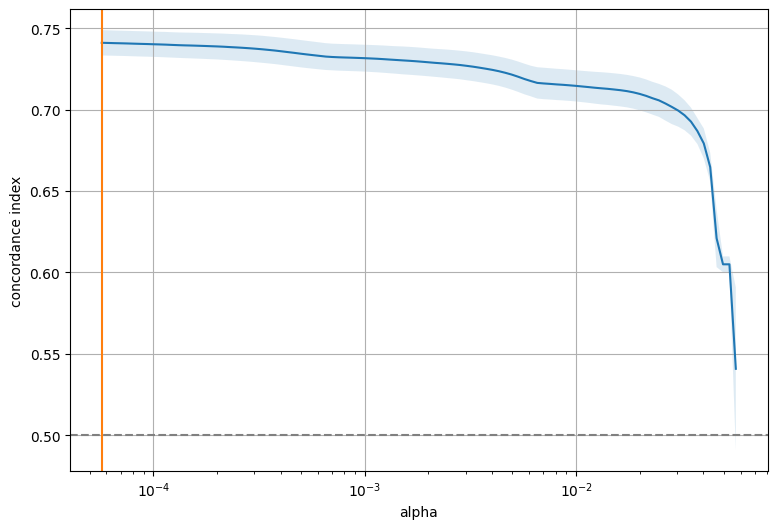

In [34]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True) 

Number of non-zero coefficients: 43


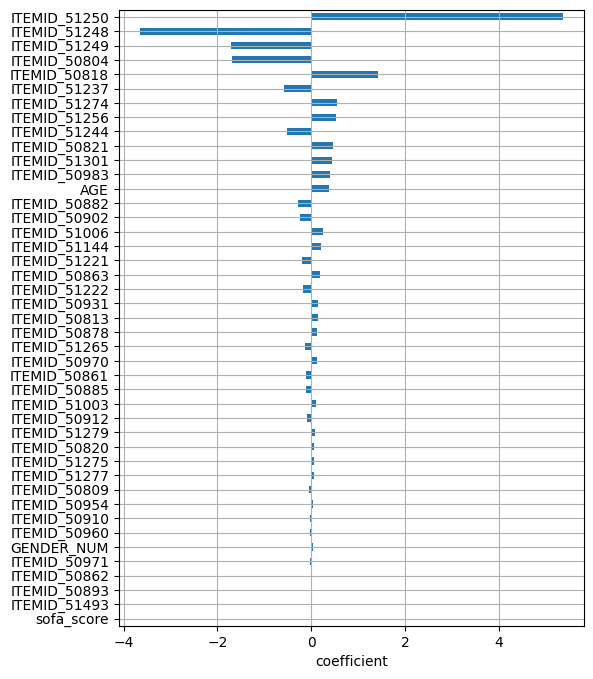

In [35]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [36]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[5.697367226133143e-05],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

In [37]:
# Concordance score
coxnet_pred.score(data_x_test,data_y_test)

0.7406676663561319

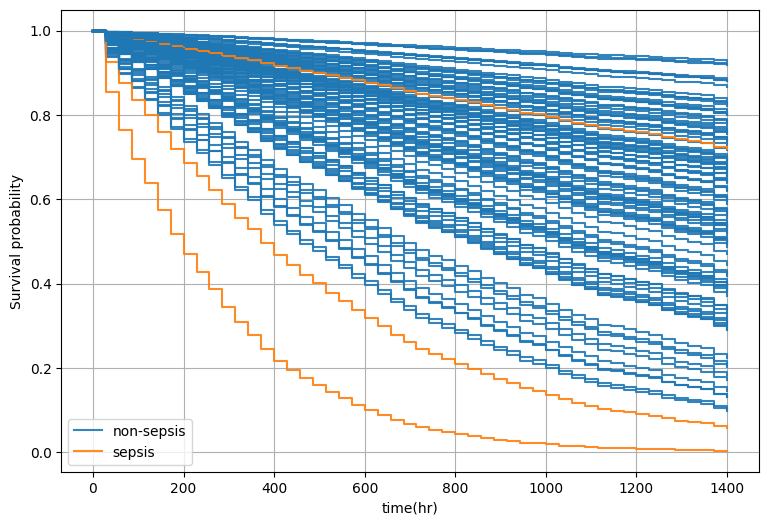

In [71]:
coxnet_surv_fns = coxnet_pred.predict_survival_function(data_x_test[1800:1900])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(coxnet_surv_fns, test_sepsis[1800:1900]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time(hr)")
ax.set_ylabel("Survival probability")
ax.grid(True)



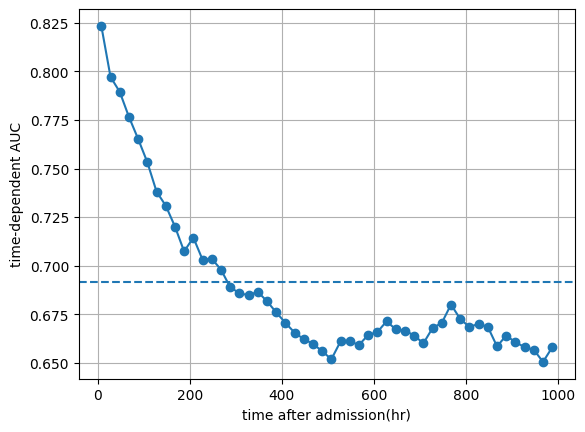

In [39]:
va_times = np.arange(8, 1000, 20)
coxnet_risk_scores = coxnet_pred.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, coxnet_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

## Random forest survival

In [26]:

# Compute sample weights based on class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=[ix[0]*1 for ix in data_y_train])


In [27]:
# fitting the Random forest survival model with few hyperparameters
rsf_gbsg = RandomSurvivalForest(n_estimators=100, min_samples_split=5, min_samples_leaf=5, n_jobs=-1, random_state=1)
rsf_gbsg.fit(data_x_train, data_y_train,sample_weight=sample_weights)


RandomSurvivalForest(min_samples_leaf=5, min_samples_split=5, n_jobs=-1,
                     random_state=1)

In [28]:
# Concordance index score
rsf_gbsg.score(data_x_test, data_y_test)

0.7951102232363036

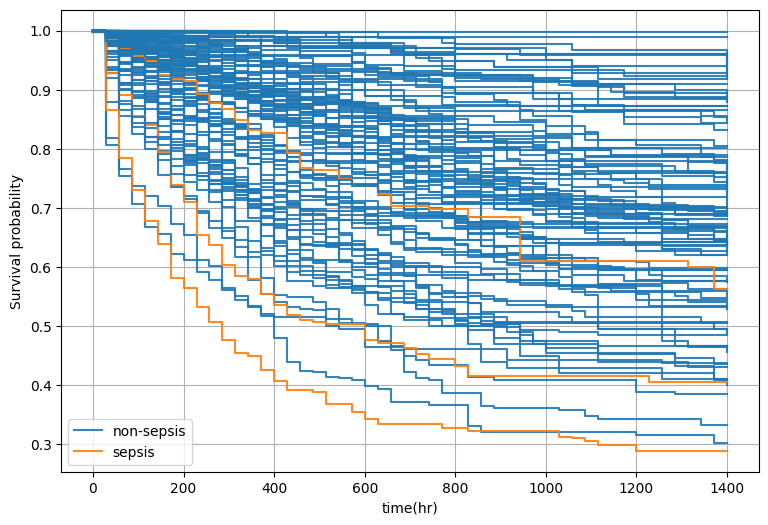

In [29]:
rsf_surv_fns = rsf_gbsg.predict_survival_function(data_x_test[1800:1900])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(rsf_surv_fns, test_sepsis[1800:1900]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time(hr)")
ax.set_ylabel("Survival probability")
ax.grid(True)

In [35]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf_gbsg, data_x_test, data_y_test, n_repeats=3)

op = pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=data_x_test.columns,
).sort_values(by="importances_mean", ascending=False)

In [ ]:
# importances of features for Random forest survival
op[:10]


,importances_mean,importances_std
AGE,0.037990,0.002113
ITEMID_50820,0.017772,0.002005
ITEMID_51144,0.011303,0.000564
ITEMID_50821,0.010067,0.000737
ITEMID_50813,0.008127,0.000608
ITEMID_50804,0.007778,0.000459
ITEMID_51301,0.007657,0.001993
ITEMID_51256,0.006721,0.000357
ITEMID_50818,0.004541,0.000432
ITEMID_51003,0.004195,0.001049


In [51]:
dataLoader.convert_itemid_to_title(op[1:10].index, df_desc_labitems)

{'ITEMID_50820': 'pH (50820)',
 'ITEMID_51144': 'Bands (51144)',
 'ITEMID_50821': 'pO2 (50821)',
 'ITEMID_50813': 'Lactate (50813)',
 'ITEMID_50804': 'Calculated Total CO2 (50804)',
 'ITEMID_51301': 'White Blood Cells (51301)',
 'ITEMID_51256': 'Neutrophils (51256)',
 'ITEMID_50818': 'pCO2 (50818)',
 'ITEMID_51003': 'Troponin T (51003)'}

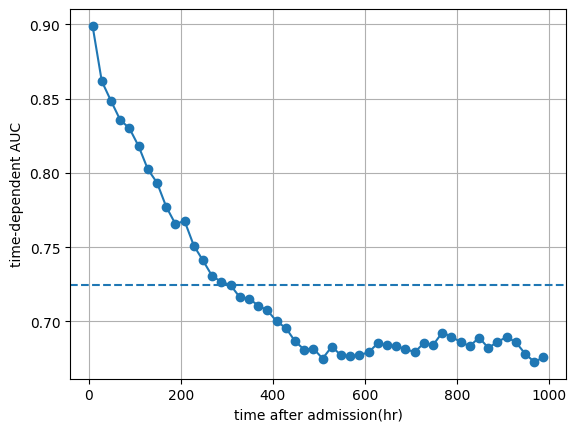

In [48]:
va_times = np.arange(8, 1000, 20)
rsf_risk_scores = rsf_gbsg.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, rsf_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

## GBM Survival

In [49]:

# fitting the gbm model on cph likelihood with regression trees as base learners
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100,learning_rate=1, max_depth=5, random_state=0)
est_cph_tree.fit(data_x_train, data_y_train)
c_index = est_cph_tree.score(data_x_test,data_y_test) 


In [50]:

# c_index score
round(est_cph_tree.score(data_x_test,data_y_test),3)


0.798

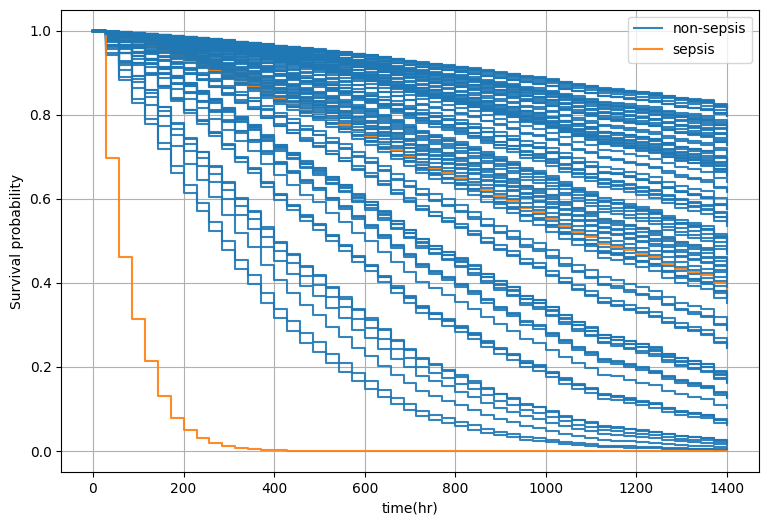

In [66]:

gbm_surv_fns = est_cph_tree.predict_survival_function(data_x_test[1800:1900])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(gbm_surv_fns, test_sepsis[1800:1900]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time(hr)")
ax.set_ylabel("Survival probability")
ax.grid(True)

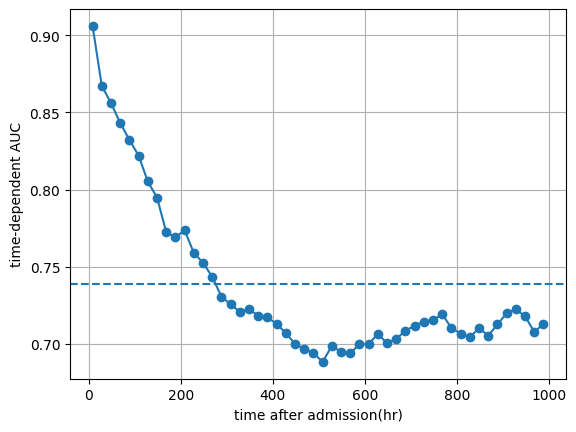

In [52]:
va_times = np.arange(8, 1000, 20)
gbm_risk_scores = est_cph_tree.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, gbm_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

# Comparison of models

### Concordance Index

In [53]:

score_cindex = pd.Series(
    [
        est_cph_tree.score(data_x_test,data_y_test),
        rsf_gbsg.score(data_x_test, data_y_test),
        coxnet_pred.score(data_x_test, data_y_test),
        estimator.score(data_x_test, data_y_test),
        0.5,
    ],
    index=["GBM","RSF", "Coxnet","cph", "Random"],
    name="c-index",
)

score_cindex.round(3)

GBM       0.798
RSF       0.795
Coxnet    0.741
cph       0.742
Random    0.500
Name: c-index, dtype: float64

In [54]:
# Calculating IBS score
lower, upper = np.percentile(df_required["total_stay"], [10, 90])
gbsg_times = np.arange(lower, upper + 1)

gbm_surv_prob = np.row_stack([fn(gbsg_times) for fn in est_cph_tree.predict_survival_function(data_x_test)])
rsf_surv_prob = np.row_stack([fn(gbsg_times) for fn in rsf_gbsg.predict_survival_function(data_x_test)])
coxnet_surv_prob = np.row_stack([fn(gbsg_times) for fn in coxnet_pred.predict_survival_function(data_x_test)])
cph_surv_prob = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(data_x_test)])

In [56]:
random_surv_prob = 0.5 * np.ones((data_y_test.shape[0], gbsg_times.shape[0]))

score_brier = pd.Series(
    [
        integrated_brier_score(df_required[["status","total_stay"]].to_records(index=False), data_y_test, prob, gbsg_times)
        for prob in (gbm_surv_prob,rsf_surv_prob, coxnet_surv_prob, cph_surv_prob, random_surv_prob)
    ],
    index=["GBM","RSF", "Coxnet", "cph", "Random"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)

,c-index,IBS
GBM,0.798,0.111
RSF,0.795,0.102
Coxnet,0.741,0.107
cph,0.742,0.107
Random,0.500,0.250


## Survival models at t4 dataset

In [ ]:
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=0, feature_no=40)
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=2, feature_no=40)
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=4, feature_no=40)

In [ ]:
path_t4_df = ROOT_DIR / 'data' / 'Model input data'/"t4.csv"  
t4 = pd.read_csv(path_t4_df)

In [ ]:
df_required = pd.merge(t4, df_demographic[["SUBJECT_ID","HADM_ID","total_stay","status"]] , on=["SUBJECT_ID","HADM_ID"], how = 'inner')



In [ ]:
df_required

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,...,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status
0,3,145834,76,0,0,13.0,265.0,8.0,28.0,7.26,...,81.0,253.0,15.6,46.4,15.3,2.79,19.1,-999.0,259.0,False
1,4,185777,47,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,89.6,207.0,12.3,31.3,13.6,3.80,9.7,-999.0,186.0,False
2,6,107064,65,1,0,22.0,146.0,1.9,34.0,7.41,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,393.0,False
3,9,150750,41,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,50.1,258.0,12.7,21.7,13.4,5.46,7.5,0.0,117.0,True
4,11,194540,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,91.4,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,613.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46015,99983,117390,78,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,-999.0,253.0,13.4,27.0,12.7,4.21,7.5,-999.0,74.0,False
46016,99985,176670,53,0,1,-999.0,-999.0,-999.0,-999.0,-999.00,...,85.1,349.0,-999.0,-999.0,14.0,4.20,13.0,-999.0,398.0,False
46017,99992,197084,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,84.9,188.0,12.9,43.9,16.3,1.35,21.4,-999.0,72.0,False
46018,99995,137810,88,1,0,36.0,96.0,1.1,52.0,7.43,...,-999.0,-999.0,19.7,35.5,-999.0,-999.00,-999.0,-999.0,77.0,False


In [ ]:
# to add sofa score for respective admissions
df_required['sofa_score'] = ef.get_sofa_score(df=df_required)

In [ ]:
df_required

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,...,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status,sofa_score
0,3,145834,76,0,0,13.0,265.0,8.0,28.0,7.26,...,253.0,15.6,46.4,15.3,2.79,19.1,-999.0,259.0,False,4
1,4,185777,47,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,207.0,12.3,31.3,13.6,3.80,9.7,-999.0,186.0,False,4
2,6,107064,65,1,0,22.0,146.0,1.9,34.0,7.41,...,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,393.0,False,-999
3,9,150750,41,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,258.0,12.7,21.7,13.4,5.46,7.5,0.0,117.0,True,-999
4,11,194540,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,613.0,False,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46015,99983,117390,78,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,253.0,13.4,27.0,12.7,4.21,7.5,-999.0,74.0,False,-999
46016,99985,176670,53,0,1,-999.0,-999.0,-999.0,-999.0,-999.00,...,349.0,-999.0,-999.0,14.0,4.20,13.0,-999.0,398.0,False,-999
46017,99992,197084,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,188.0,12.9,43.9,16.3,1.35,21.4,-999.0,72.0,False,4
46018,99995,137810,88,1,0,36.0,96.0,1.1,52.0,7.43,...,-999.0,19.7,35.5,-999.0,-999.00,-999.0,-999.0,77.0,False,-999


In [ ]:
# dropping the patients who have sepsis but not died untill discharge

df_required = df_required.drop(df_required[(df_required['IS_SEPSIS']==1) & (df_required['status']==False)].index)


In [ ]:
# censored and non-censored count of instances
df_required["status"].value_counts()

status
False    37173
True      5419
Name: count, dtype: int64

In [ ]:
df_required = df_required.drop(["SUBJECT_ID","HADM_ID"], axis = 1)
#DROPPINg the 70% missing values rows
df_required = filter_missing_rows(df_required, 70) 

In [ ]:
# splitting of data into training and test set
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(
    #df_required.drop(["status","total_stay","IS_SEPSIS"], axis=1),  # dropping the target column for X values
    df_required.drop(["status","total_stay"], axis=1),  # dropping the target column for X values
    df_required[["status","total_stay"]],
    test_size=0.2,  # this means 20% test set
    stratify=df_required['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)

In [ ]:
len(data_y_train[(data_x_train["IS_SEPSIS"]==0) ])

29210

<Axes: >

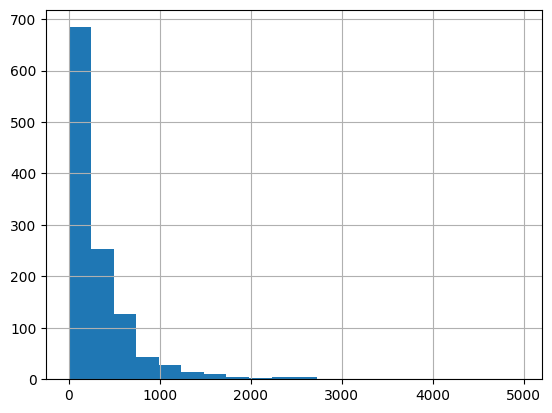

In [ ]:
data_y_train[(data_x_train["IS_SEPSIS"]==1) ]['total_stay'].hist(bins=20)

In [ ]:
# Standard Scalerisation
train_categorical = pd.DataFrame(data_x_train[["GENDER_NUM","IS_SEPSIS"]]).reset_index(drop=True)
test_categorical = pd.DataFrame(data_x_test[["GENDER_NUM","IS_SEPSIS"]]).reset_index(drop=True)

scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(data_x_train.drop(["GENDER_NUM","IS_SEPSIS"], axis=1))
scaled_x_train_columns= data_x_train.drop(["GENDER_NUM","IS_SEPSIS"], axis=1).columns

scaled_x_test = scaler.transform(data_x_test.drop(["GENDER_NUM","IS_SEPSIS"], axis=1))
scaled_x_test_columns= data_x_test.drop(["GENDER_NUM","IS_SEPSIS"], axis=1).columns

data_x_train = pd.DataFrame(scaled_x_train, columns=scaled_x_train_columns)
data_x_test = pd.DataFrame(scaled_x_test, columns=scaled_x_test_columns)
data_x_train = pd.concat([data_x_train, train_categorical], axis=1)
data_x_test = pd.concat([data_x_test, test_categorical], axis=1)

# dropping of sepsis column from the respective training  and test data
data_x_train = data_x_train.drop(["IS_SEPSIS"], axis = 1)
test_sepsis = data_x_test["IS_SEPSIS"]    # labesls of sepsis of test data
data_x_test = data_x_test.drop("IS_SEPSIS", axis = 1)

In [ ]:
# conversion to structured format
data_y_train = data_y_train.to_records(index=False)
data_y_test = data_y_test.to_records(index=False)
data_y_train

rec.array([(False, 142.), (False,  98.), (False,  67.), ...,
           (False, 358.), (False,  58.), (False, 192.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

In [ ]:
data_y_train.dtype

dtype((numpy.record, [('status', '?'), ('total_stay', '<f8')]))

### 1. Cox PH Survival Model

In [ ]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_train, data_y_train)

CoxPHSurvivalAnalysis()

In [ ]:
# prediction of survival risk 
pred_surv = estimator.predict_survival_function(data_x_test[2400:2500])


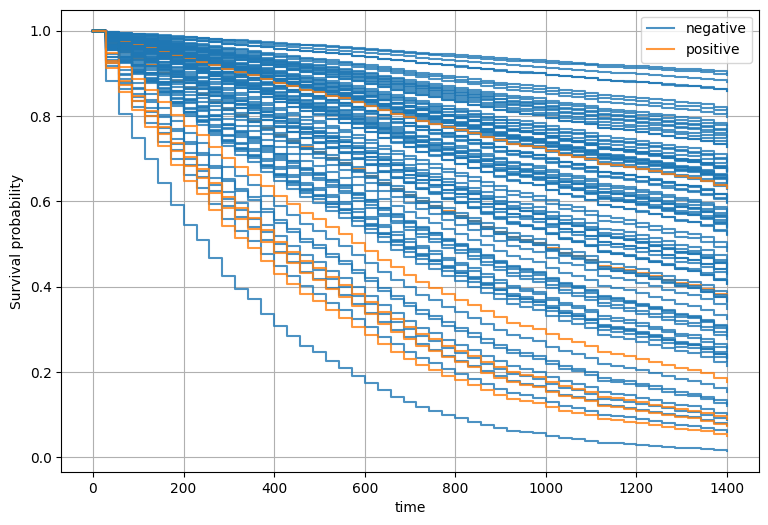

In [ ]:

time_points =  np.linspace(0, 1400)
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(pred_surv, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.8)
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

In [ ]:
# Concordance index score
print(estimator.score(data_x_test, data_y_test))

0.7278175950669481


In [ ]:
# which single variable is best risk predictor
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x_train.values, data_y_train)
#displayong the top 10 features
pd.Series(scores, index=data_x_train.columns).sort_values(ascending=False)[:10]

ITEMID_50813    0.645812
ITEMID_51006    0.613601
ITEMID_51274    0.605302
ITEMID_51237    0.604265
ITEMID_51301    0.602776
ITEMID_50821    0.600170
ITEMID_50818    0.597104
AGE             0.595251
ITEMID_51144    0.594017
ITEMID_50912    0.593307
dtype: float64

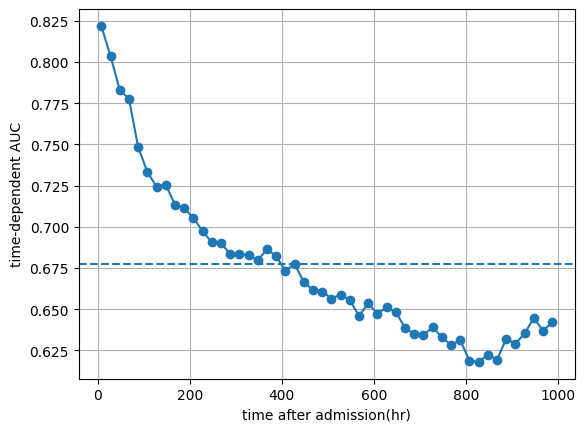

In [ ]:
# Time-independent AUC curve
va_times = np.arange(8, 1000, 20)
cph_risk_scores = estimator.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, cph_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

### 2. coxnet model

In [ ]:
Xt = data_x_train.copy()
y = data_y_train.copy()

In [ ]:

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=100))
#warnings.simplefilter("ignore", UserWarning)
#warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.001, l1_ratio=0.9,
                                        max_iter=100))])

In [ ]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

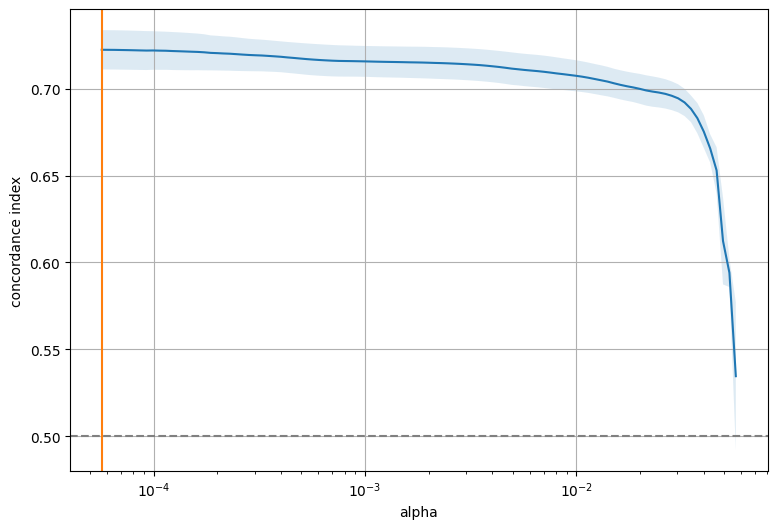

In [ ]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True) 

Number of non-zero coefficients: 42


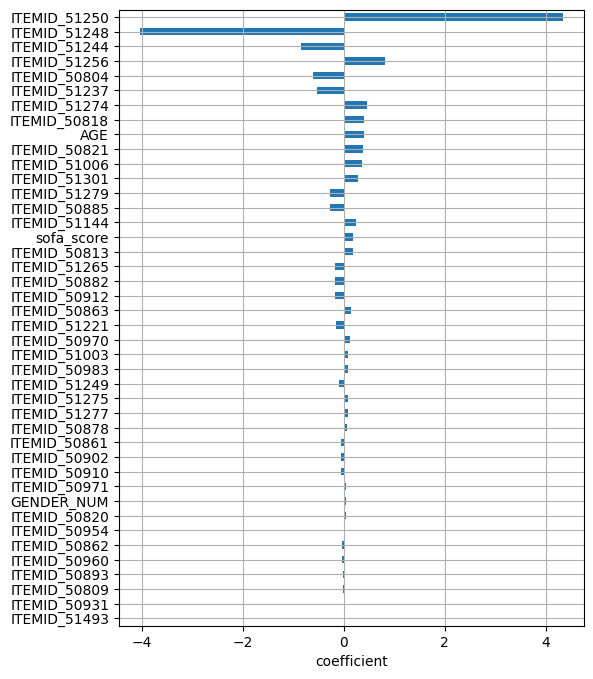

In [ ]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [ ]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[5.6743058867389196e-05],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

In [ ]:
# Concordance score
coxnet_pred.score(data_x_test,data_y_test)

0.716540308713724

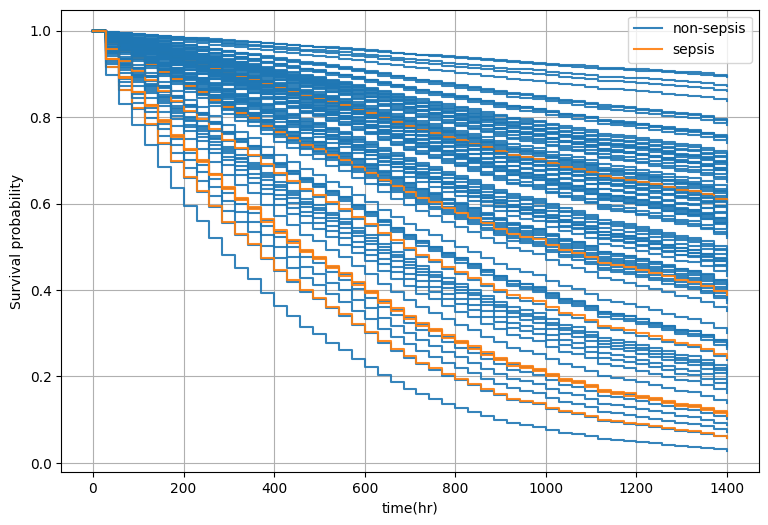

In [ ]:
coxnet_surv_fns = coxnet_pred.predict_survival_function(data_x_test[2400:2500])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(coxnet_surv_fns, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time(hr)")
ax.set_ylabel("Survival probability")
ax.grid(True)



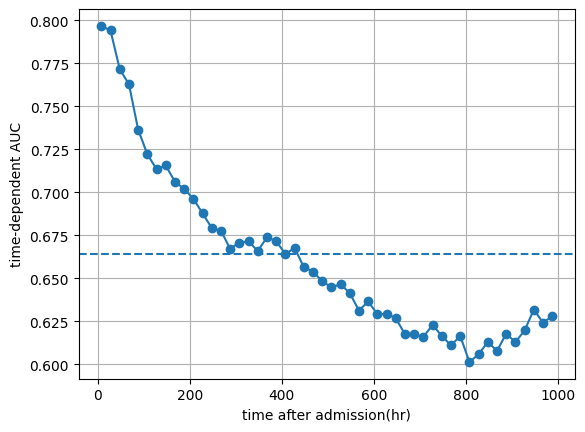

In [ ]:
va_times = np.arange(8, 1000, 20)
coxnet_risk_scores = coxnet_pred.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, coxnet_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

In [ ]:

# concordance score
coxnet_pred.score(data_x_test,data_y_test)

0.716540308713724

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")
        
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

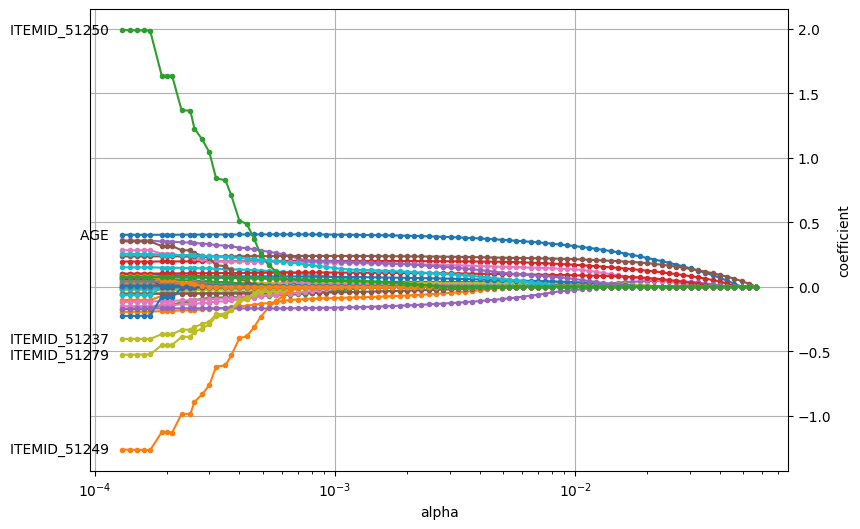

In [ ]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=Xt.columns, columns=np.round(cox_elastic_net.alphas_,5)
)


plot_coefficients(coefficients_elastic_net, n_highlight=5)

## Random forest survival

In [ ]:

# Compute sample weights based on class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=[ix[0]*1 for ix in data_y_train])


In [ ]:
# fitting the Random forest survival model with few hyperparameters
rsf_gbsg = RandomSurvivalForest(n_estimators=100, min_samples_split=5, min_samples_leaf=5, n_jobs=-1, random_state=1)
rsf_gbsg.fit(data_x_train, data_y_train,sample_weight=sample_weights)


RandomSurvivalForest(min_samples_leaf=5, min_samples_split=5, n_jobs=-1,
                     random_state=1)

In [ ]:
# Concordance index score
rsf_gbsg.score(data_x_test, data_y_test)

0.7720825593250297

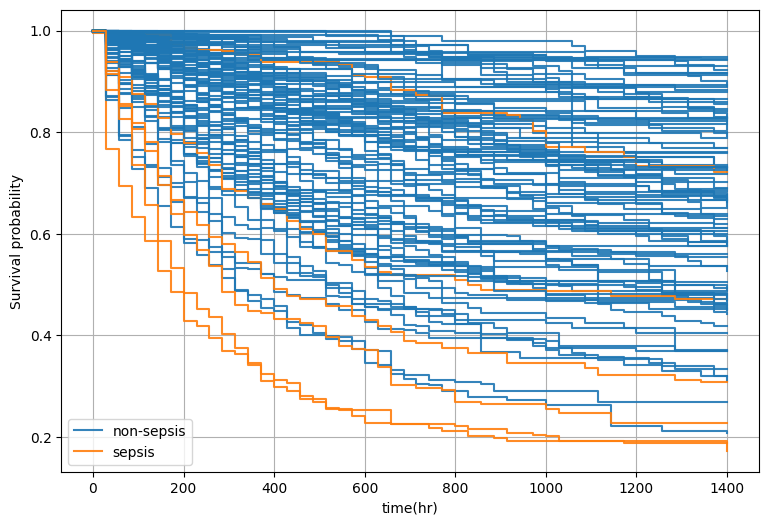

In [ ]:
rsf_surv_fns = rsf_gbsg.predict_survival_function(data_x_test[2400:2500])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(rsf_surv_fns, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time(hr)")
ax.set_ylabel("Survival probability")
ax.grid(True)

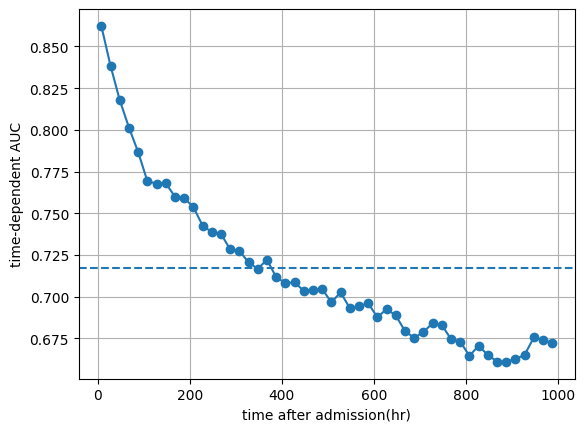

In [ ]:
va_times = np.arange(8, 1000, 20)
rsf_risk_scores = rsf_gbsg.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, rsf_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

## GBM Survival

In [ ]:

# fitting the gbm model on cph likelihood with regression trees as base learners
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100,learning_rate=1, max_depth=5, random_state=0)
est_cph_tree.fit(data_x_train, data_y_train)
c_index = est_cph_tree.score(data_x_test,data_y_test)


In [ ]:

# c_index score
round(est_cph_tree.score(data_x_test,data_y_test),3)


0.768

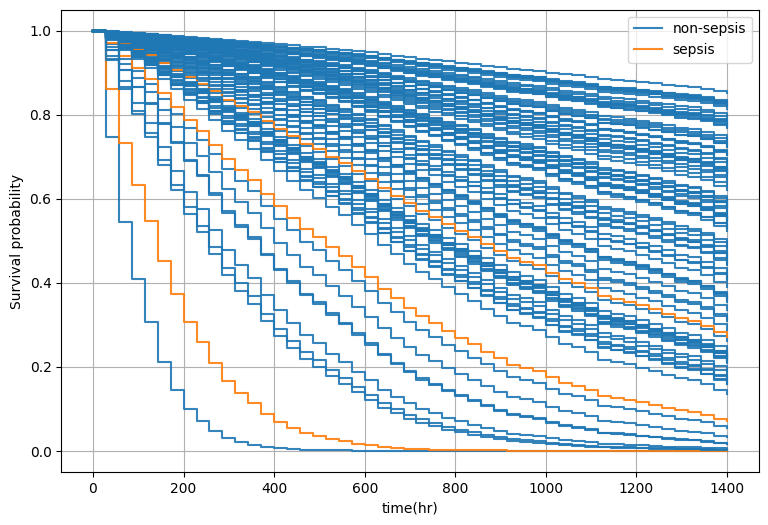

In [ ]:

gbm_surv_fns = est_cph_tree.predict_survival_function(data_x_test[1800:1900])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(gbm_surv_fns, test_sepsis[1800:1900]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time(hr)")
ax.set_ylabel("Survival probability")
ax.grid(True)

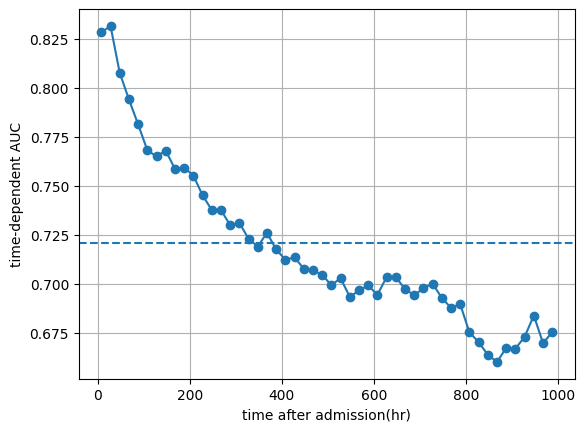

In [ ]:
va_times = np.arange(8, 1000, 20)
gbm_risk_scores = est_cph_tree.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, gbm_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

# Comparison of models

### Concordance Index

In [ ]:

score_cindex = pd.Series(
    [
        est_cph_tree.score(data_x_test,data_y_test),
        rsf_gbsg.score(data_x_test, data_y_test),
        coxnet_pred.score(data_x_test, data_y_test),
        estimator.score(data_x_test, data_y_test),
        0.5,
    ],
    index=["GBM","RSF", "Coxnet","cph", "Random"],
    name="c-index",
)

score_cindex.round(3)

GBM       0.768
RSF       0.772
Coxnet    0.717
cph       0.728
Random    0.500
Name: c-index, dtype: float64

In [ ]:
# Calculating IBS score
lower, upper = np.percentile(df_required["total_stay"], [10, 90])
gbsg_times = np.arange(lower, upper + 1)

gbm_surv_prob = np.row_stack([fn(gbsg_times) for fn in est_cph_tree.predict_survival_function(data_x_test)])
rsf_surv_prob = np.row_stack([fn(gbsg_times) for fn in rsf_gbsg.predict_survival_function(data_x_test)])
coxnet_surv_prob = np.row_stack([fn(gbsg_times) for fn in coxnet_pred.predict_survival_function(data_x_test)])
cph_surv_prob = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(data_x_test)])

In [ ]:
random_surv_prob = 0.5 * np.ones((data_y_test.shape[0], gbsg_times.shape[0]))

score_brier = pd.Series(
    [
        integrated_brier_score(df_required[["status","total_stay"]].to_records(index=False), data_y_test, prob, gbsg_times)
        for prob in (gbm_surv_prob,rsf_surv_prob, coxnet_surv_prob, cph_surv_prob, random_surv_prob)
    ],
    index=["GBM","RSF", "Coxnet", "cph", "Random"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)

,c-index,IBS
GBM,0.768,0.112
RSF,0.772,0.104
Coxnet,0.717,0.111
cph,0.728,0.110
Random,0.500,0.249


## Suurvival models on t2 dataset

In [ ]:
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=0, feature_no=40)
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=2, feature_no=40)
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=6, feature_no=40)

In [ ]:
path_t2_df = ROOT_DIR / 'data' / 'Model input data'/"t2.csv"  
t2 = pd.read_csv(path_t2_df)

In [ ]:
df_required = pd.merge(t2, df_demographic[["SUBJECT_ID","HADM_ID","total_stay","status"]] , on=["SUBJECT_ID","HADM_ID"], how = 'inner')



In [ ]:
df_required

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,...,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status
0,3,145834,76,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,81.0,282.0,13.5,30.7,15.1,3.44,12.7,-999.0,259.0,False
1,4,185777,47,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,89.6,207.0,12.3,31.3,13.6,3.80,9.7,-999.0,186.0,False
2,6,107064,65,1,0,28.0,106.0,1.0,44.0,7.39,...,-999.0,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,393.0,False
3,9,150750,41,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,50.1,258.0,12.7,21.7,13.4,5.46,7.5,0.0,117.0,True
4,11,194540,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,91.4,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,613.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42645,99982,183791,65,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,73.8,163.0,13.9,34.3,15.7,3.83,7.1,-999.0,147.0,False
42646,99985,176670,53,0,1,-999.0,-999.0,-999.0,-999.0,-999.00,...,85.1,349.0,-999.0,-999.0,14.0,4.20,13.0,-999.0,398.0,False
42647,99992,197084,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,84.9,188.0,12.9,43.9,16.3,1.35,21.4,-999.0,72.0,False
42648,99995,137810,88,1,0,33.0,100.0,1.1,33.0,7.59,...,-999.0,-999.0,19.7,35.5,-999.0,-999.00,-999.0,-999.0,77.0,False


In [ ]:
# to add sofa score for respective admissions
df_required['sofa_score'] = ef.get_sofa_score(df=df_required)

In [ ]:
df_required

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,...,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status,sofa_score
0,3,145834,76,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,282.0,13.5,30.7,15.1,3.44,12.7,-999.0,259.0,False,-999
1,4,185777,47,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,207.0,12.3,31.3,13.6,3.80,9.7,-999.0,186.0,False,4
2,6,107064,65,1,0,28.0,106.0,1.0,44.0,7.39,...,-999.0,-999.0,-999.0,-999.0,-999.00,-999.0,-999.0,393.0,False,-999
3,9,150750,41,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,258.0,12.7,21.7,13.4,5.46,7.5,0.0,117.0,True,-999
4,11,194540,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,613.0,False,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42645,99982,183791,65,0,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,163.0,13.9,34.3,15.7,3.83,7.1,-999.0,147.0,False,-999
42646,99985,176670,53,0,1,-999.0,-999.0,-999.0,-999.0,-999.00,...,349.0,-999.0,-999.0,14.0,4.20,13.0,-999.0,398.0,False,-999
42647,99992,197084,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.00,...,188.0,12.9,43.9,16.3,1.35,21.4,-999.0,72.0,False,4
42648,99995,137810,88,1,0,33.0,100.0,1.1,33.0,7.59,...,-999.0,19.7,35.5,-999.0,-999.00,-999.0,-999.0,77.0,False,-999


In [ ]:
# dropping the patients who have sepsis but not died untill discharge

df_required = df_required.drop(df_required[(df_required['IS_SEPSIS']==1) & (df_required['status']==False)].index)


In [ ]:
# censored and non-censored count of instances
df_required["status"].value_counts()

status
False    34221
True      5156
Name: count, dtype: int64

In [ ]:
df_required = df_required.drop(["SUBJECT_ID","HADM_ID"], axis = 1)
#DROPPINg the 70% missing values rows
df_required = filter_missing_rows(df_required, 70) 

In [ ]:
# splitting of data into training and test set
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(
    #df_required.drop(["status","total_stay","IS_SEPSIS"], axis=1),  # dropping the target column for X values
    df_required.drop(["status","total_stay"], axis=1),  # dropping the target column for X values
    df_required[["status","total_stay"]],
    test_size=0.2,  # this means 20% test set
    stratify=df_required['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)

In [ ]:
len(data_y_train[(data_x_train["IS_SEPSIS"]==0) ])

26218

<Axes: >

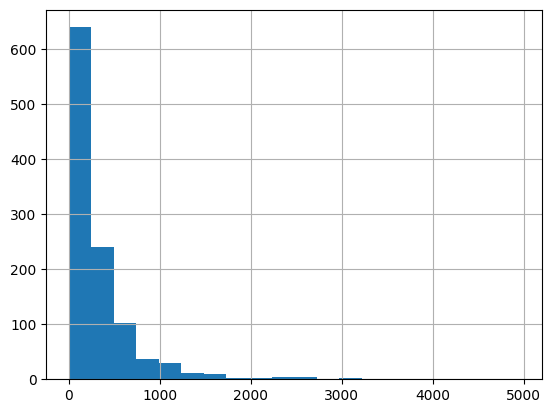

In [ ]:
data_y_train[(data_x_train["IS_SEPSIS"]==1) ]['total_stay'].hist(bins=20)

In [ ]:
# Standard Scalerisation
train_categorical = pd.DataFrame(data_x_train[["GENDER_NUM","IS_SEPSIS"]]).reset_index(drop=True)
test_categorical = pd.DataFrame(data_x_test[["GENDER_NUM","IS_SEPSIS"]]).reset_index(drop=True)

scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(data_x_train.drop(["GENDER_NUM","IS_SEPSIS"], axis=1))
scaled_x_train_columns= data_x_train.drop(["GENDER_NUM","IS_SEPSIS"], axis=1).columns

scaled_x_test = scaler.transform(data_x_test.drop(["GENDER_NUM","IS_SEPSIS"], axis=1))
scaled_x_test_columns= data_x_test.drop(["GENDER_NUM","IS_SEPSIS"], axis=1).columns

data_x_train = pd.DataFrame(scaled_x_train, columns=scaled_x_train_columns)
data_x_test = pd.DataFrame(scaled_x_test, columns=scaled_x_test_columns)
data_x_train = pd.concat([data_x_train, train_categorical], axis=1)
data_x_test = pd.concat([data_x_test, test_categorical], axis=1)

# dropping of sepsis column from the respective training  and test data
data_x_train = data_x_train.drop(["IS_SEPSIS"], axis = 1)
test_sepsis = data_x_test["IS_SEPSIS"]    # labesls of sepsis of test data
data_x_test = data_x_test.drop("IS_SEPSIS", axis = 1)

In [ ]:
# conversion to structured format
data_y_train = data_y_train.to_records(index=False)
data_y_test = data_y_test.to_records(index=False)
data_y_train

rec.array([(False, 243.), (False, 293.), (False, 224.), ...,
           (False,  12.), (False, 106.), ( True, 212.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

In [ ]:
data_y_train.dtype

dtype((numpy.record, [('status', '?'), ('total_stay', '<f8')]))

### 1. Cox PH Survival Model

In [ ]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_train, data_y_train)

CoxPHSurvivalAnalysis()

In [ ]:
# prediction of survival risk 
pred_surv = estimator.predict_survival_function(data_x_test[2400:2500])


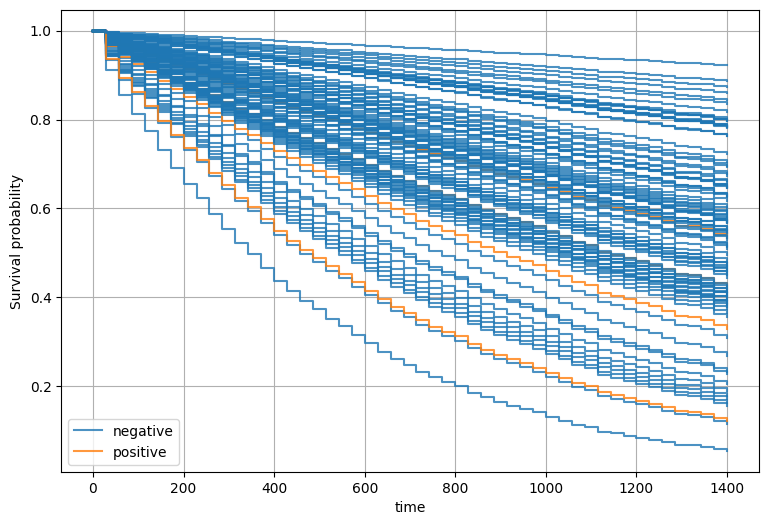

In [ ]:

time_points =  np.linspace(0, 1400)
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(pred_surv, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.8)
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

In [ ]:
# Concordance index score
print(estimator.score(data_x_test, data_y_test))

0.7148834497049202


In [ ]:
# which single variable is best risk predictor
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x_train.values, data_y_train)
#displayong the top 10 features
pd.Series(scores, index=data_x_train.columns).sort_values(ascending=False)[:10]

ITEMID_50813    0.631224
ITEMID_51006    0.605410
ITEMID_50882    0.603576
ITEMID_51274    0.598849
AGE             0.598160
ITEMID_51237    0.597732
ITEMID_51301    0.597143
ITEMID_50821    0.593563
ITEMID_50818    0.590075
ITEMID_51144    0.586753
dtype: float64

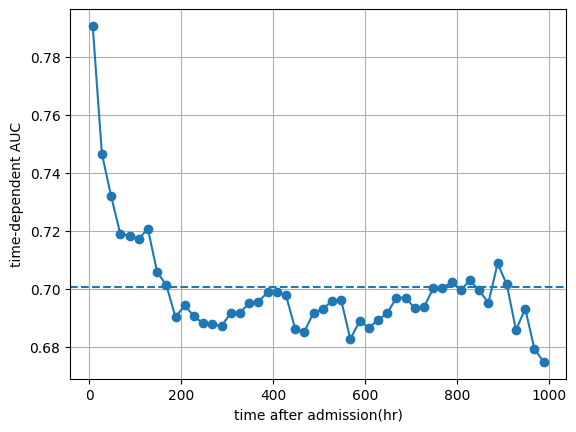

In [ ]:
# Time-independent AUC curve
va_times = np.arange(8, 1000, 20)
cph_risk_scores = estimator.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, cph_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

# coxnet model

In [ ]:
Xt = data_x_train.copy()
y = data_y_train.copy()

In [ ]:

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.8, alpha_min_ratio=0.001, max_iter=100))
#warnings.simplefilter("ignore", UserWarning)
#warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.001, l1_ratio=0.8,
                                        max_iter=100))])

In [ ]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

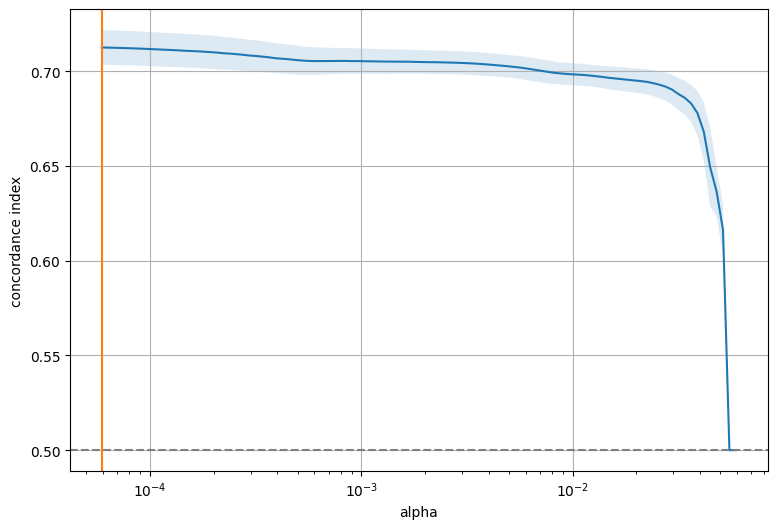

In [ ]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True) 

Number of non-zero coefficients: 42


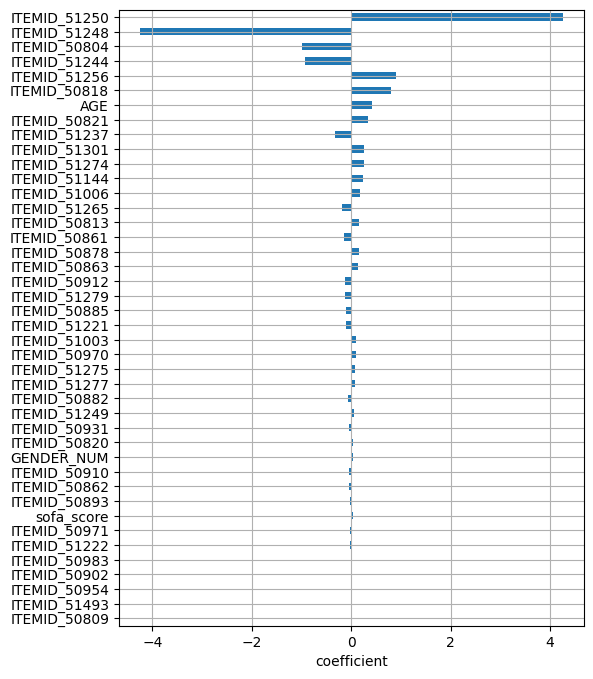

In [ ]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [ ]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alphas=[5.917412452262306e-05],
                                        fit_baseline_model=True,
                                        l1_ratio=0.9))])

In [ ]:
# Concordance score
coxnet_pred.score(data_x_test,data_y_test)

0.7144809601857579

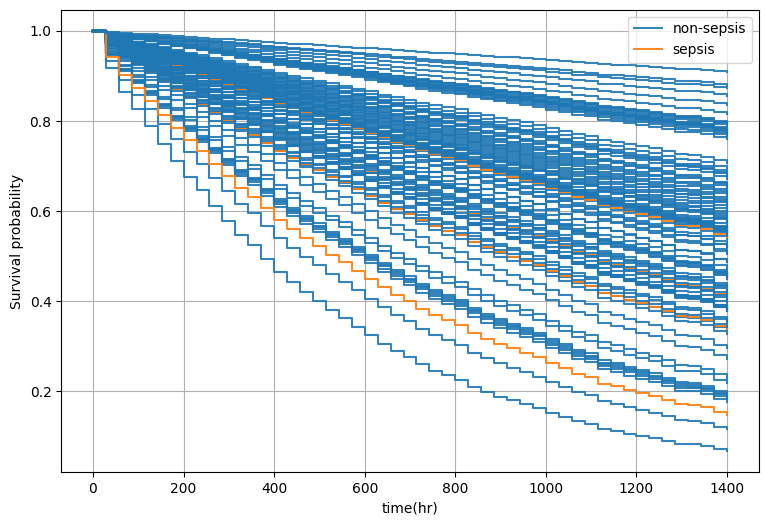

In [ ]:
coxnet_surv_fns = coxnet_pred.predict_survival_function(data_x_test[2400:2500])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(coxnet_surv_fns, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time(hr)")
ax.set_ylabel("Survival probability")
ax.grid(True)



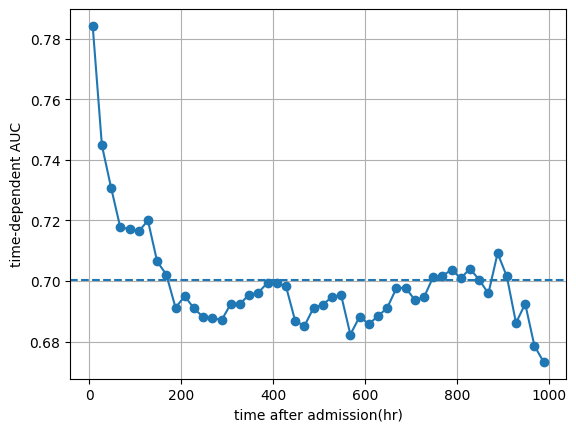

In [ ]:
va_times = np.arange(8, 1000, 20)
coxnet_risk_scores = coxnet_pred.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, coxnet_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")

plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

In [ ]:

# concordance score
coxnet_pred.score(data_x_test,data_y_test)

0.7144809601857579

In [ ]:
def plot_coefficients(coefs, n_highlight):
    _, ax = plt.subplots(figsize=(9, 6))
    n_features = coefs.shape[0]
    alphas = coefs.columns
    for row in coefs.itertuples():
        ax.semilogx(alphas, row[1:], ".-", label=row.Index)

    alpha_min = alphas.min()
    top_coefs = coefs.loc[:, alpha_min].map(abs).sort_values().tail(n_highlight)
    for name in top_coefs.index:
        coef = coefs.loc[name, alpha_min]
        plt.text(alpha_min, coef, name + "   ", horizontalalignment="right", verticalalignment="center")
        
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    ax.grid(True)
    ax.set_xlabel("alpha")
    ax.set_ylabel("coefficient")

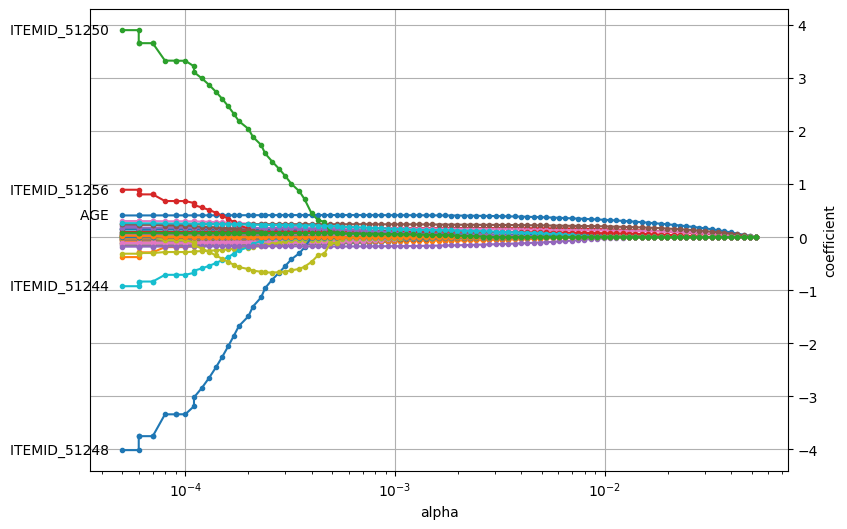

In [ ]:
coefficients_elastic_net = pd.DataFrame(
    cox_elastic_net.coef_, index=Xt.columns, columns=np.round(cox_elastic_net.alphas_,5)
)

plot_coefficients(coefficients_elastic_net, n_highlight=5)

## Random forest survival

In [ ]:

# Compute sample weights based on class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=[ix[0]*1 for ix in data_y_train])


In [ ]:
# fitting the Random forest survival model with few hyperparameters
rsf_gbsg = RandomSurvivalForest(n_estimators=100, min_samples_split=5, min_samples_leaf=5, n_jobs=-1, random_state=1)
rsf_gbsg.fit(data_x_train, data_y_train,sample_weight=sample_weights)


RandomSurvivalForest(min_samples_leaf=5, min_samples_split=5, n_jobs=-1,
                     random_state=1)

In [ ]:
# Concordance index score
rsf_gbsg.score(data_x_test, data_y_test)

0.762992039475665

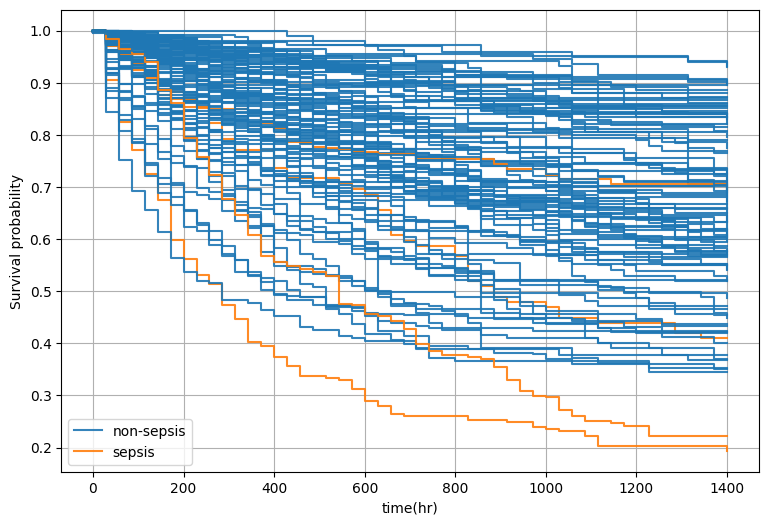

In [ ]:
rsf_surv_fns = rsf_gbsg.predict_survival_function(data_x_test[2400:2500])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(rsf_surv_fns, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time(hr)")
ax.set_ylabel("Survival probability")
ax.grid(True)

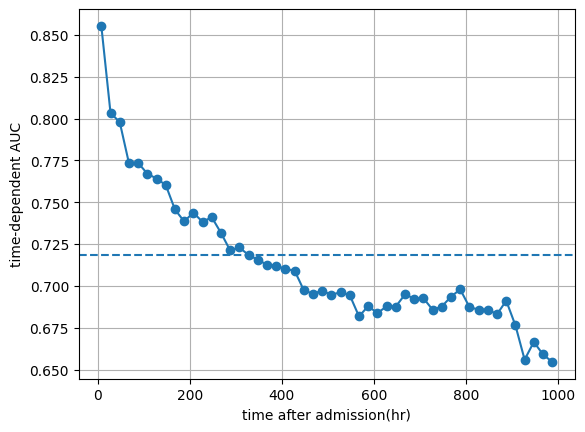

In [ ]:
va_times = np.arange(8, 1000, 20)
rsf_risk_scores = rsf_gbsg.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, rsf_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

## GBM Survival

In [ ]:

# fitting the gbm model on cph likelihood with regression trees as base learners
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0)
est_cph_tree.fit(data_x_train, data_y_train)
c_index = est_cph_tree.score(data_x_test,data_y_test)


In [ ]:

# c_index score
round(est_cph_tree.score(data_x_test,data_y_test),3)


0.759

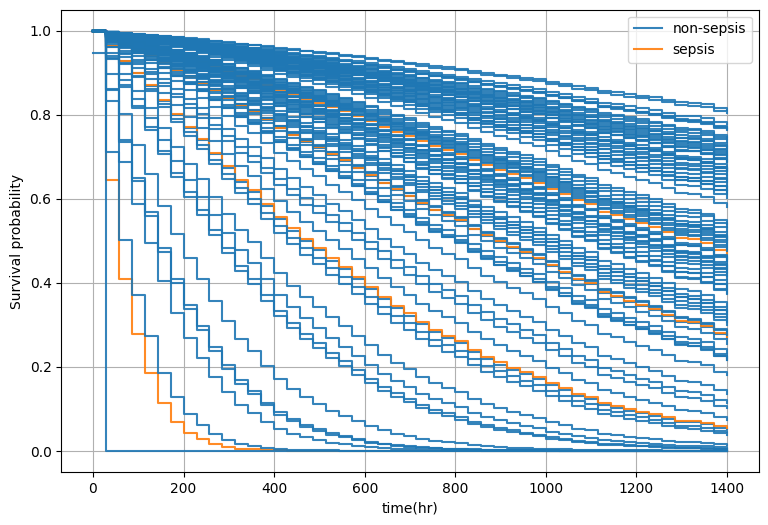

In [ ]:

gbm_surv_fns = est_cph_tree.predict_survival_function(data_x_test[1800:1900])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(gbm_surv_fns, test_sepsis[1800:1900]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time(hr)")
ax.set_ylabel("Survival probability")
ax.grid(True)

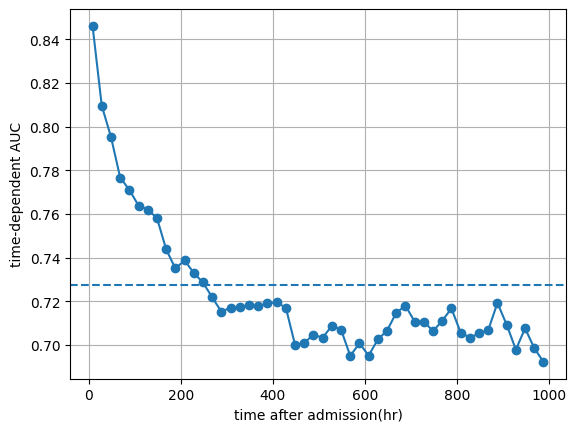

In [ ]:
va_times = np.arange(8, 1000, 20)
gbm_risk_scores = est_cph_tree.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, gbm_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

# Comparison of models

### Concordance Index

In [ ]:

score_cindex = pd.Series(
    [
        est_cph_tree.score(data_x_test,data_y_test),
        rsf_gbsg.score(data_x_test, data_y_test),
        coxnet_pred.score(data_x_test, data_y_test),
        estimator.score(data_x_test, data_y_test),
        0.5,
    ],
    index=["GBM","RSF", "Coxnet","cph", "Random"],
    name="c-index",
)

score_cindex.round(3)

GBM       0.759
RSF       0.763
Coxnet    0.714
cph       0.715
Random    0.500
Name: c-index, dtype: float64

In [ ]:
# Calculating IBS score
lower, upper = np.percentile(df_required["total_stay"], [10, 90])
gbsg_times = np.arange(lower, upper + 1)

gbm_surv_prob = np.row_stack([fn(gbsg_times) for fn in est_cph_tree.predict_survival_function(data_x_test)])
rsf_surv_prob = np.row_stack([fn(gbsg_times) for fn in rsf_gbsg.predict_survival_function(data_x_test)])
coxnet_surv_prob = np.row_stack([fn(gbsg_times) for fn in coxnet_pred.predict_survival_function(data_x_test)])
cph_surv_prob = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(data_x_test)])

In [ ]:
random_surv_prob = 0.5 * np.ones((data_y_test.shape[0], gbsg_times.shape[0]))

score_brier = pd.Series(
    [
        integrated_brier_score(df_required[["status","total_stay"]].to_records(index=False), data_y_test, prob, gbsg_times)
        for prob in (gbm_surv_prob,rsf_surv_prob, coxnet_surv_prob, cph_surv_prob, random_surv_prob)
    ],
    index=["GBM","RSF", "Coxnet", "cph", "Random"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)

,c-index,IBS
GBM,0.759,0.124
RSF,0.763,0.112
Coxnet,0.714,0.116
cph,0.715,0.116
Random,0.500,0.250


## Survival Models on t0 dataset

In [ ]:
dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=0, feature_no=40)
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=2, feature_no=40)
#dataLoader.create_train_data(df_labevents, df_demographic, df_desc_labitems, hours=6, feature_no=40)

In [ ]:
path_t0_df = ROOT_DIR / 'data' / 'Model input data'/"t0.csv"  
t0 = pd.read_csv(path_t0_df)

In [ ]:
# preparing the final data frame to split in train and test set
df_required = pd.merge(t0, df_demographic[["SUBJECT_ID","HADM_ID","total_stay","status"]] , on=["SUBJECT_ID","HADM_ID"], how = 'inner')



In [ ]:
df_required

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,...,ITEMID_51256,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status
0,3,145834,76,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,81.0,282.0,13.5,30.7,15.1,3.44,12.7,-999.0,259.0,False
1,4,185777,47,1,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,89.6,207.0,-999.0,-999.0,13.6,3.80,9.7,-999.0,186.0,False
2,9,150750,41,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,50.1,258.0,12.7,21.7,13.4,5.46,7.5,-999.0,117.0,True
3,11,194540,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,91.4,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,613.0,False
4,12,112213,72,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,-999.0,339.0,-999.0,-999.0,14.2,4.15,7.7,-999.0,305.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34989,99966,167228,77,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,77.4,185.0,12.5,25.8,15.3,4.17,11.0,-999.0,40.0,False
34990,99973,150202,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,78.5,323.0,14.6,29.2,15.5,3.25,17.2,-999.0,107.0,False
34991,99982,112748,65,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,77.9,145.0,24.8,40.0,16.5,3.48,6.1,-999.0,164.0,False
34992,99985,176670,53,0,1,-999.0,-999.0,-999.0,-999.0,-999.0,...,85.1,349.0,-999.0,-999.0,14.0,4.20,13.0,-999.0,398.0,False


In [ ]:
# to add sofa score for respective admissions
df_required['sofa_score'] = ef.get_sofa_score(df=df_required)

In [ ]:
df_required

,SUBJECT_ID,HADM_ID,AGE,GENDER_NUM,IS_SEPSIS,ITEMID_50804,ITEMID_50809,ITEMID_50813,ITEMID_50818,ITEMID_50820,...,ITEMID_51265,ITEMID_51274,ITEMID_51275,ITEMID_51277,ITEMID_51279,ITEMID_51301,ITEMID_51493,total_stay,status,sofa_score
0,3,145834,76,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,282.0,13.5,30.7,15.1,3.44,12.7,-999.0,259.0,False,-999
1,4,185777,47,1,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,207.0,-999.0,-999.0,13.6,3.80,9.7,-999.0,186.0,False,4
2,9,150750,41,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,258.0,12.7,21.7,13.4,5.46,7.5,-999.0,117.0,True,-999
3,11,194540,50,1,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,229.0,13.0,28.3,13.4,4.31,8.5,-999.0,613.0,False,-999
4,12,112213,72,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,339.0,-999.0,-999.0,14.2,4.15,7.7,-999.0,305.0,True,-999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34989,99966,167228,77,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,185.0,12.5,25.8,15.3,4.17,11.0,-999.0,40.0,False,-999
34990,99973,150202,65,1,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,323.0,14.6,29.2,15.5,3.25,17.2,-999.0,107.0,False,-999
34991,99982,112748,65,0,0,-999.0,-999.0,-999.0,-999.0,-999.0,...,145.0,24.8,40.0,16.5,3.48,6.1,-999.0,164.0,False,-999
34992,99985,176670,53,0,1,-999.0,-999.0,-999.0,-999.0,-999.0,...,349.0,-999.0,-999.0,14.0,4.20,13.0,-999.0,398.0,False,-999


In [ ]:
# dropping the patients who have sepsis but not died untill discharge

df_required = df_required.drop(df_required[(df_required['IS_SEPSIS']==1) & (df_required['status']==False)].index)


In [ ]:
df_required["status"].value_counts()

status
False    27843
True      4345
Name: count, dtype: int64

In [ ]:
df_required = df_required.drop(["SUBJECT_ID","HADM_ID"], axis = 1)
#DROPPINg the 70% missing values rows
df_required = filter_missing_rows(df_required, 70) 

In [ ]:
# splitting of data into training and test set
data_x_train, data_x_test, data_y_train, data_y_test = train_test_split(
    #df_required.drop(["status","total_stay","IS_SEPSIS"], axis=1),  # dropping the target column for X values
    df_required.drop(["status","total_stay"], axis=1),  # dropping the target column for X values
    df_required[["status","total_stay"]],
    test_size=0.2,  # this means 20% test set
    stratify=df_required['IS_SEPSIS'],  # stratify by the target variable
    random_state=42  # to ensure reproducibility
)

In [ ]:
len(data_y_train[(data_x_train["IS_SEPSIS"]==0) ])

20962

<Axes: >

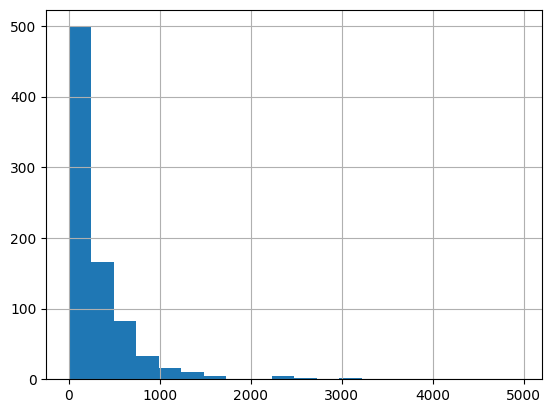

In [ ]:
data_y_train[(data_x_train["IS_SEPSIS"]==1) ]['total_stay'].hist(bins=20)

In [ ]:
# Standard Scalerisation
train_categorical = pd.DataFrame(data_x_train[["GENDER_NUM","IS_SEPSIS"]]).reset_index(drop=True)
test_categorical = pd.DataFrame(data_x_test[["GENDER_NUM","IS_SEPSIS"]]).reset_index(drop=True)

scaler = StandardScaler()
scaled_x_train = scaler.fit_transform(data_x_train.drop(["GENDER_NUM","IS_SEPSIS"], axis=1))
scaled_x_train_columns= data_x_train.drop(["GENDER_NUM","IS_SEPSIS"], axis=1).columns

scaled_x_test = scaler.transform(data_x_test.drop(["GENDER_NUM","IS_SEPSIS"], axis=1))
scaled_x_test_columns= data_x_test.drop(["GENDER_NUM","IS_SEPSIS"], axis=1).columns

data_x_train = pd.DataFrame(scaled_x_train, columns=scaled_x_train_columns)
data_x_test = pd.DataFrame(scaled_x_test, columns=scaled_x_test_columns)
data_x_train = pd.concat([data_x_train, train_categorical], axis=1)
data_x_test = pd.concat([data_x_test, test_categorical], axis=1)

# dropping of sepsis column from the respective training  and test data
data_x_train = data_x_train.drop(["IS_SEPSIS"], axis = 1)
test_sepsis = data_x_test["IS_SEPSIS"]    # labesls of sepsis of test data
data_x_test = data_x_test.drop("IS_SEPSIS", axis = 1)

In [ ]:
# conversion to structured format
data_y_train = data_y_train.to_records(index=False)
data_y_test = data_y_test.to_records(index=False)
data_y_train

rec.array([(False, 123.), (False,  76.), (False,  92.), ...,
           (False,  87.), (False,  92.), ( True, 123.)],
          dtype=[('status', '?'), ('total_stay', '<f8')])

In [ ]:
data_y_train.dtype

dtype((numpy.record, [('status', '?'), ('total_stay', '<f8')]))

### 1. Cox PH Survival Model

In [ ]:
set_config(display="text")  # displays text representation of estimators

estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_train, data_y_train)

CoxPHSurvivalAnalysis()

In [ ]:
# prediction of survival risk 
pred_surv = estimator.predict_survival_function(data_x_test[2400:2500])


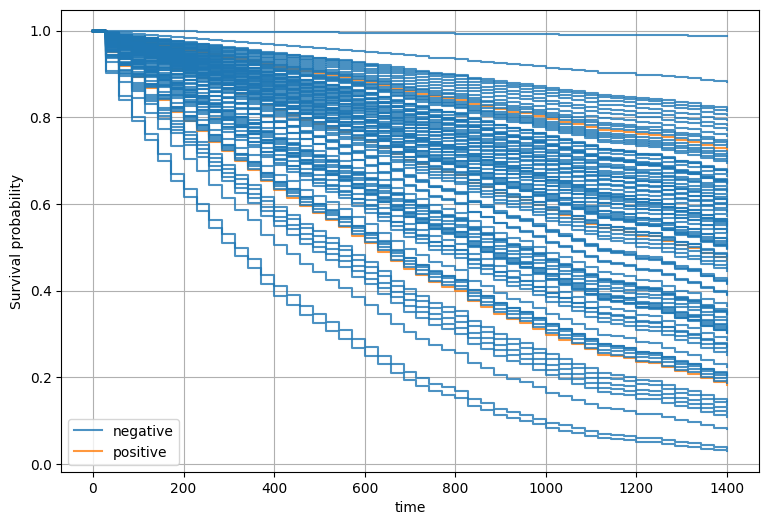

In [ ]:

time_points =  np.linspace(0, 1400)
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(pred_surv, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.8)
    if len(legend_handles) <= label:
        name = "positive" if label == 1 else "negative"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time")
ax.set_ylabel("Survival probability")
ax.grid(True)

In [ ]:
# Concordance index score
print(estimator.score(data_x_test, data_y_test))

0.6790616007976338


In [ ]:
# which single variable is best risk predictor
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j : j + 1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores


scores = fit_and_score_features(data_x_train.values, data_y_train)
#displayong the top 10 features
pd.Series(scores, index=data_x_train.columns).sort_values(ascending=False)[:10]

AGE             0.607544
ITEMID_50882    0.600223
ITEMID_51006    0.595193
ITEMID_51301    0.594637
ITEMID_51274    0.587815
ITEMID_51237    0.586859
ITEMID_51144    0.583232
ITEMID_51249    0.580803
ITEMID_51275    0.575145
ITEMID_51003    0.561389
dtype: float64

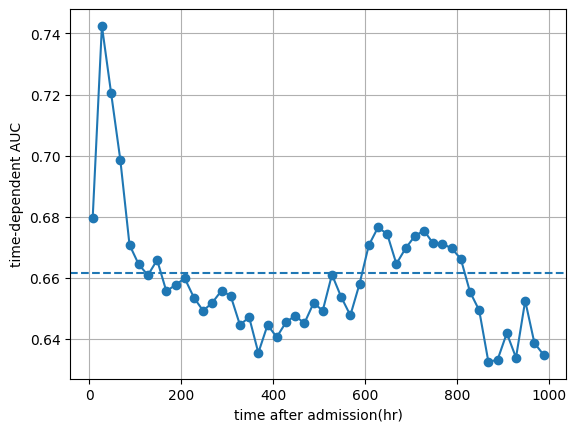

In [ ]:
# Time-independent AUC curve
va_times = np.arange(8, 1000, 20)
cph_risk_scores = estimator.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, cph_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

### 2. Coxnet model

In [ ]:
Xt = data_x_train.copy()
y = data_y_train.copy()

In [ ]:

coxnet_pipe = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.8, alpha_min_ratio=0.001, max_iter=100))
#warnings.simplefilter("ignore", UserWarning)
#warnings.simplefilter("ignore", FitFailedWarning)
coxnet_pipe.fit(Xt, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('coxnetsurvivalanalysis',
                 CoxnetSurvivalAnalysis(alpha_min_ratio=0.001, l1_ratio=0.8,
                                        max_iter=100))])

In [ ]:
estimated_alphas = coxnet_pipe.named_steps["coxnetsurvivalanalysis"].alphas_
cv = KFold(n_splits=5, shuffle=True, random_state=0)
gcv = GridSearchCV(
    make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9)),
    param_grid={"coxnetsurvivalanalysis__alphas": [[v] for v in estimated_alphas]},
    cv=cv,
    error_score=0.5,
    n_jobs=1,
).fit(Xt, y)

cv_results = pd.DataFrame(gcv.cv_results_)

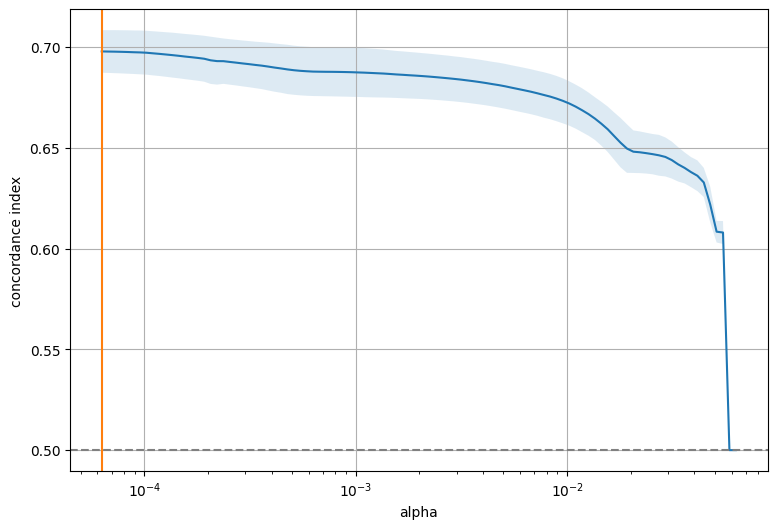

In [ ]:
alphas = cv_results.param_coxnetsurvivalanalysis__alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(gcv.best_params_["coxnetsurvivalanalysis__alphas"][0], c="C1")
ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True) 

Number of non-zero coefficients: 43


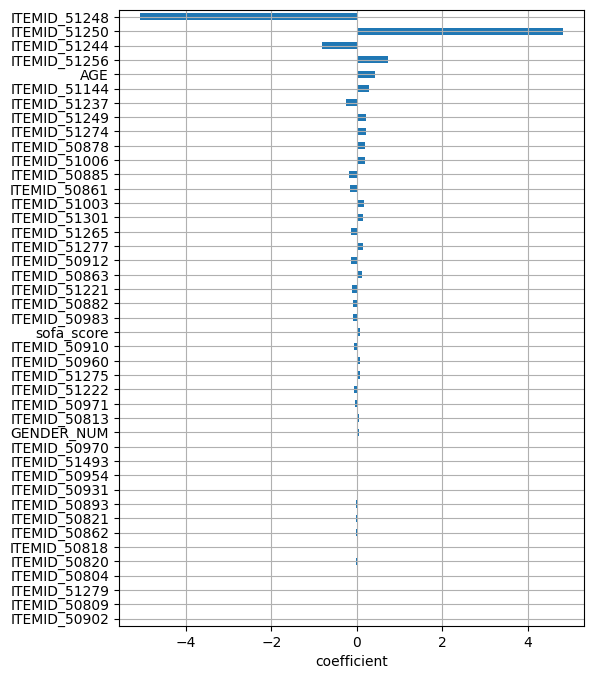

In [ ]:
best_model = gcv.best_estimator_.named_steps["coxnetsurvivalanalysis"]

best_coefs = pd.DataFrame(best_model.coef_, index=Xt.columns, columns=["coefficient"])

non_zero = np.sum(best_coefs.iloc[:, 0] != 0)
print(f"Number of non-zero coefficients: {non_zero}")

non_zero_coefs = best_coefs.query("coefficient != 0")
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

_, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)

In [ ]:
coxnet_pred = make_pipeline(StandardScaler(), CoxnetSurvivalAnalysis(l1_ratio=0.9, fit_baseline_model=True))
coxnet_pred.set_params(**gcv.best_params_)
coxnet_pred.fit(Xt, y)
# Concordance score
coxnet_pred.score(data_x_test,data_y_test)

0.6774074851244978

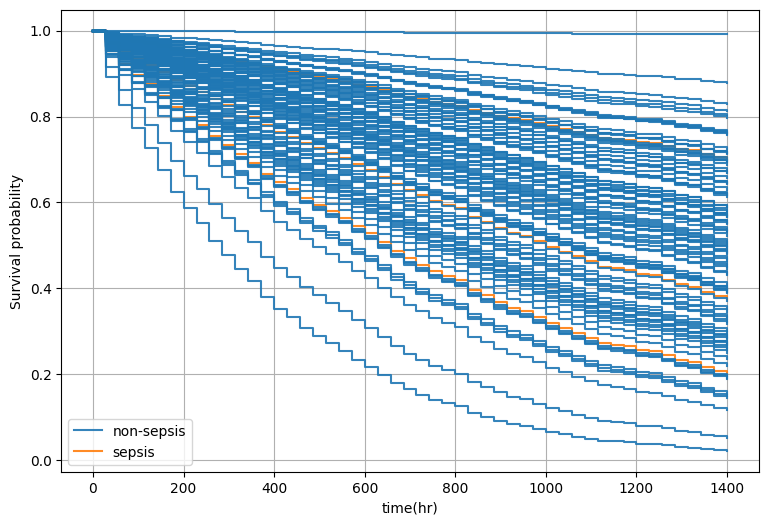

In [ ]:
coxnet_surv_fns = coxnet_pred.predict_survival_function(data_x_test[2400:2500])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(coxnet_surv_fns, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time(hr)")
ax.set_ylabel("Survival probability")
ax.grid(True)



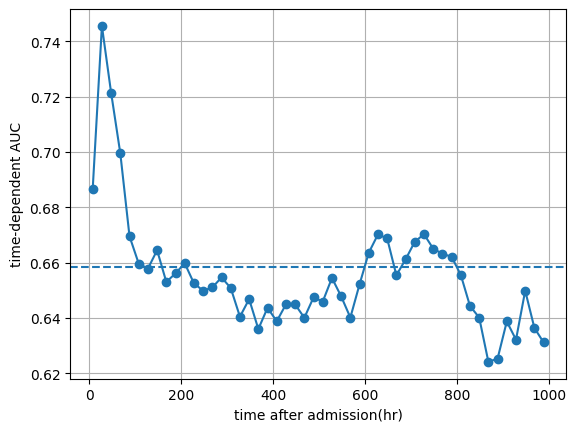

In [ ]:
va_times = np.arange(8, 1000, 20)
coxnet_risk_scores = coxnet_pred.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, coxnet_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

In [ ]:
surv_fns = coxnet_pred.predict(data_x_test)
result = concordance_index_censored(data_y_test["status"], data_y_test["total_stay"], surv_fns)
result[0]

0.6774074851244978

## Random forest survival

In [ ]:

# Compute sample weights based on class imbalance
sample_weights = compute_sample_weight(class_weight='balanced', y=[ix[0]*1 for ix in data_y_train])


In [ ]:
# fitting the Random forest survival model with few hyperparameters
rsf_gbsg = RandomSurvivalForest(n_estimators=100, min_samples_split=5, min_samples_leaf=5, n_jobs=-1, random_state=1)
rsf_gbsg.fit(data_x_train, data_y_train,sample_weight=sample_weights)


RandomSurvivalForest(min_samples_leaf=5, min_samples_split=5, n_jobs=-1,
                     random_state=1)

In [ ]:
# Concordance index score
rsf_gbsg.score(data_x_test, data_y_test)

0.7276455059807575

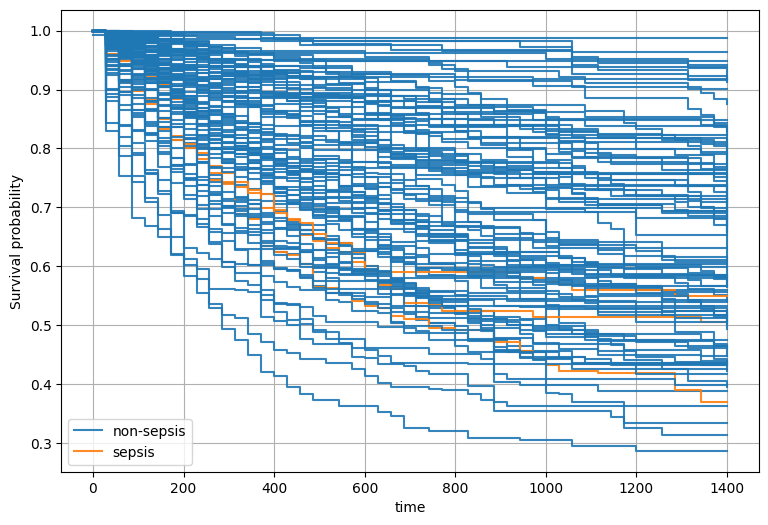

In [ ]:
rsf_surv_fns = rsf_gbsg.predict_survival_function(data_x_test[2400:2500])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(rsf_surv_fns, test_sepsis[2400:2500]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time(hr)")
ax.set_ylabel("Survival probability")
ax.grid(True)

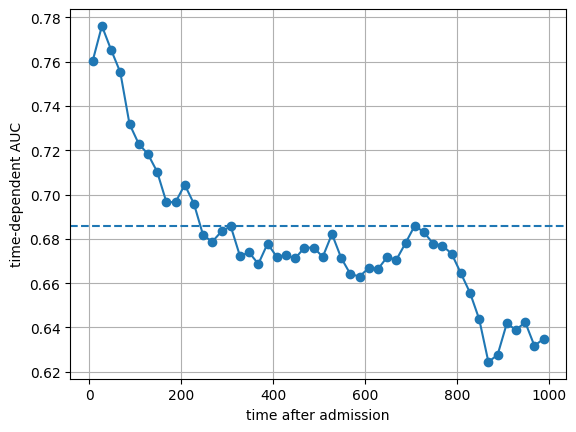

In [ ]:
va_times = np.arange(8, 1000, 20)
rsf_risk_scores = rsf_gbsg.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, rsf_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

## GBM Survival

In [ ]:

# fitting the gbm model on cph likelihood with regression trees as base learners
est_cph_tree = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=1.0, max_depth=5, random_state=0)
est_cph_tree.fit(data_x_train, data_y_train)
c_index = est_cph_tree.score(data_x_test,data_y_test)
print(round(c_index, 3))

0.733


In [ ]:

# c_index score
round(est_cph_tree.score(data_x_test,data_y_test),3)


0.733

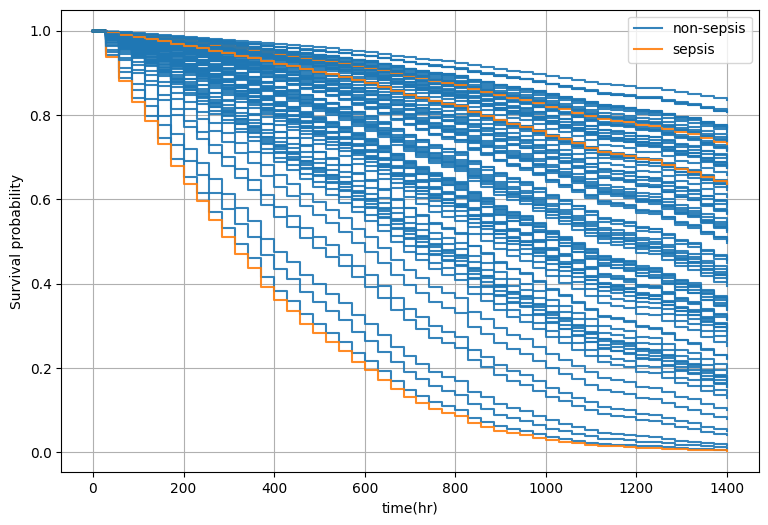

In [ ]:

gbm_surv_fns = est_cph_tree.predict_survival_function(data_x_test[1800:1900])

time_points =  np.linspace(0, 1400)
#time_points = np.quantile(y["total_stay"], np.linspace(0, 0.6, 100))
legend_handles = []
legend_labels = []
_, ax = plt.subplots(figsize=(9, 6))
for fn, label in zip(gbm_surv_fns, test_sepsis[1800:1900]):
    (line,) = ax.step(time_points, fn(time_points), where="post", color=f"C{label}", alpha=0.9)
    
    if len(legend_handles) <= label:
        name = "sepsis" if label == 1 else "non-sepsis"
        legend_labels.append(name)
        legend_handles.append(line)

ax.legend(legend_handles, legend_labels)
ax.set_xlabel("time(hr)")
ax.set_ylabel("Survival probability")
ax.grid(True)

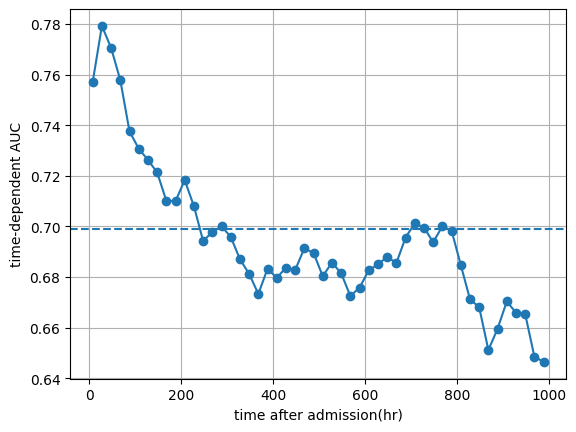

In [ ]:
va_times = np.arange(8, 1000, 20)
gbm_risk_scores = est_cph_tree.predict(data_x_test)
cph_auc, cph_mean_auc = cumulative_dynamic_auc(data_y_train, data_y_test, gbm_risk_scores, va_times)

plt.plot(va_times, cph_auc, marker="o")
plt.axhline(cph_mean_auc, linestyle="--")
plt.xlabel("time after admission(hr)")
plt.ylabel("time-dependent AUC")
plt.grid(True)

# Comparison of models

### Concordance Index

In [ ]:

score_cindex = pd.Series(
    [
        est_cph_tree.score(data_x_test,data_y_test),
        rsf_gbsg.score(data_x_test, data_y_test),
        coxnet_pred.score(data_x_test, data_y_test),
        estimator.score(data_x_test, data_y_test),
        0.5,
    ],
    index=["GBM","RSF", "Coxnet","cph", "Random"],
    name="c-index",
)

score_cindex.round(3)

GBM       0.733
RSF       0.728
Coxnet    0.677
cph       0.679
Random    0.500
Name: c-index, dtype: float64

In [ ]:
# Calculating IBS score
lower, upper = np.percentile(df_required["total_stay"], [10, 90])
gbsg_times = np.arange(lower, upper + 1)

gbm_surv_prob = np.row_stack([fn(gbsg_times) for fn in est_cph_tree.predict_survival_function(data_x_test)])
rsf_surv_prob = np.row_stack([fn(gbsg_times) for fn in rsf_gbsg.predict_survival_function(data_x_test)])
coxnet_surv_prob = np.row_stack([fn(gbsg_times) for fn in coxnet_pred.predict_survival_function(data_x_test)])
cph_surv_prob = np.row_stack([fn(gbsg_times) for fn in estimator.predict_survival_function(data_x_test)])

In [ ]:
random_surv_prob = 0.5 * np.ones((data_y_test.shape[0], gbsg_times.shape[0]))

score_brier = pd.Series(
    [
        integrated_brier_score(df_required[["status","total_stay"]].to_records(index=False), data_y_test, prob, gbsg_times)
        for prob in (gbm_surv_prob,rsf_surv_prob, coxnet_surv_prob, cph_surv_prob, random_surv_prob)
    ],
    index=["GBM","RSF", "Coxnet", "cph", "Random"],
    name="IBS",
)

pd.concat((score_cindex, score_brier), axis=1).round(3)

,c-index,IBS
GBM,0.733,0.128
RSF,0.728,0.116
Coxnet,0.677,0.119
cph,0.679,0.120
Random,0.500,0.248
